### **HW11.1 - Fine tune BERT model on Triage data set for classification**

Task 1: prepare data on local computer

For task one, I wrote code to reformat the triage data to work with fine-tuning for Bert. The file is called convert.py, and can be found on the class Github. To view the file, following this link (not direct download): https://tufts.box.com/s/7963vri60ouz1ajobjyh0680tr6mofdj


Task 2: Fine tuning Bert

For this task, I used the following tutorial on the reformatted triage dataset. I fine-tuned Bert with the following:
- Try 2-3 different BERT model versions
- Try adding another dense layer to the classifier

At the bottom of this collab notebook, I discuss my results after fine-tuning.


# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on the triage dataset.

In this notebook, you will:

- Load the triage dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

## Setup


In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

In [ ]:
!pip install "tf-models-official==2.13.*"

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

### Download the Triage dataset

Let's download and extract the dataset, then explore the directory structure.


In [4]:
import requests
import zipfile
import os

url = 'https://tufts.box.com/shared/static/15eobaqkhfzqskx5euvxhpwnxmk8fscl.zip'

# Stream the download
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open('triage.zip', 'wb') as f:
        f.write(response.content)

# Unzip the downloaded file
with zipfile.ZipFile('triage.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

# Set the directory paths
dataset_dir = 'triage'
train_dir = os.path.join(dataset_dir, 'train')
dev_dir = os.path.join(dataset_dir, 'dev')


In [49]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/dev',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 21046 files belonging to 2 classes.
Using 16837 files for training.
Found 21046 files belonging to 2 classes.
Using 4209 files for validation.
Found 2573 files belonging to 2 classes.


Let's take a look at a few lines from the triage dataset.

In [22]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Text: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Text: b'yesterday night i slept squatting the ground was wet'
Label : 1 (1)
Text: b'hi please give me a card of 500'
Label : 0 (0)
Text: b'i want a scholarship in another country and after return to haiti'
Label : 0 (0)


In [9]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        text = text_batch.numpy()[i].decode('utf-8')
        print(f'Text: {text}')
        label = label_batch.numpy()[i]
        print(f'Label: {label} ({class_names[label]})')


Text: every year during the rainy season from september to january the chamroeun community located in meanchey district phnom penh suffers from the onslaught of relentless monsoon rains
Label: 0 (0)
Text: we have found nothing nothing at all
Label: 0 (0)
Text: e it has been suggested that wfp analyse the results of the ongoing evaluation missions and if necessary proceed in a coordinated manner to programme food aid into september due to the anticipated flood and drought inflicted crop damages
Label: 1 (1)


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.


In [50]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# CHOOSING BERT MODELS TO FINE-TUNE
In order to choose 2-3 models that are different enough. Here are the following models I picked to fine-tune to:
- BERT-based UNCASED: suitable for general-purpose language understanding tasks and offers a balance between size, speed, and accuracy.
- Small BERT: less computationally expensive. Faster but slightly less accurate.
- Albert: four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.

I predictation is that BERT-based UNCASED will have the best validation accuracy, following by small BERT and Alberta.


## The preprocessing model



In [51]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [52]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [53]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [54]:
bert_results = bert_model(text_preprocessed)

# print(f'Loaded BERT: {tfhub_handle_encoder}')
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [55]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)

  # Add another dense layer if wanted
  net = tf.keras.layers.Dense(128, activation='relu')(net)

  # Final classification layer
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [56]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6463442]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

In [ ]:
# tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [57]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [59]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [60]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [47]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

81/81 [==============================] - 8s 102ms/step - loss: 0.5232 - binary_accuracy: 0.7960
Loss: 0.5232368111610413
Accuracy: 0.7959580421447754


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


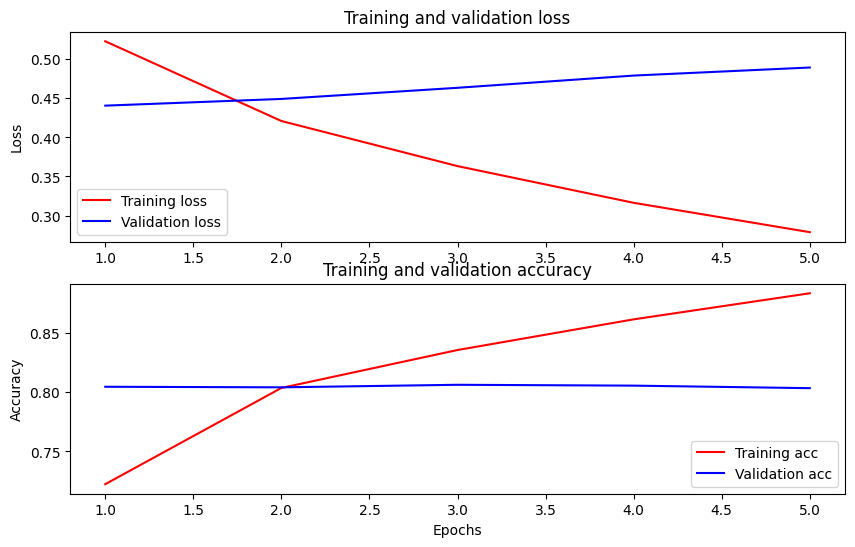

In [48]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

# FINAL EVALUATION OF EACH MODEL

(1) Changing Models
- BERT-based UNCASED:

accuracy and loss over time: https://drive.google.com/file/d/1lZBPIWQtXD33aJHxWB0R5vwd2MWhqeZI/view?usp=sharing

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3

Epoch 1/5
loss: 0.5036 - binary_accuracy: 0.7454 - val_loss: 0.4109 - val_binary_accuracy: 0.8035

Epoch 2/5
loss: 0.3669 - binary_accuracy: 0.8372 - val_loss: 0.4472 - val_binary_accuracy: 0.8066

Epoch 3/5
loss: 0.2447 - binary_accuracy: 0.9023 - val_loss: 0.5488 - val_binary_accuracy: 0.8040

Epoch 4/5
loss: 0.1521 - binary_accuracy: 0.9457 - val_loss: 0.7340 - val_binary_accuracy: 0.7933

Epoch 5/5
loss: 0.0999 - binary_accuracy: 0.9675 - val_loss: 0.8651 - val_binary_accuracy: 0.8019

Loss: 0.9687227606773376
Accuracy: 0.7862417697906494

**Training and Validation Results Over Epochs:**

Epoch 1: The model starts with a loss of 0.5036 and a binary accuracy of 74.54%. The validation loss is lower at 0.4109 with a higher accuracy of 80.35%. This means the model is learning and performing well on the validation set.

Epoch 2: The training loss decreases and accuracy increases. However, validation loss increases slightly, and the validation accuracy also improves a tiny bit. This might show overfitting.

Epochs 3-5: The training loss keeps decreasing and accuracy increases a lot. The validation loss increases, and validation accuracy slightly decreases by the fifth epoch. This shows that the model is overfitting to the training data by the later epochs and is losing its generalization to test data.

Final loss and accuracy: 0.9687 and 78.62%. The accuracy is reasonably high. The increase in loss compared to what was in the last epoch, however, means there may be some problems with model generalization.

Possible solutions: Adding early stopping, regularization and dropouts. Tuning the hyperparameters. Data augmentation (preprocessing). Lowering the number of epochs.

- Small BERT:

Accuracy and loss over time:
https://drive.google.com/file/d/1zAf-FSlwVwg5746nU5Ikj4j2qBwZ2oKs/view?usp=sharing

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1

Epoch 1/5
loss: 0.5253 - binary_accuracy: 0.7253 - val_loss: 0.4367 - val_binary_accuracy: 0.8068

Epoch 2/5
loss: 0.4192 - binary_accuracy: 0.8026 - val_loss: 0.4393 - val_binary_accuracy: 0.8085

Epoch 3/5
loss: 0.3632 - binary_accuracy: 0.8351 - val_loss: 0.4508 - val_binary_accuracy: 0.8033

Epoch 4/5
loss: 0.3123 - binary_accuracy: 0.8627 - val_loss: 0.4882 - val_binary_accuracy: 0.8014

Epoch 5/5
loss: 0.2795 - binary_accuracy: 0.8815 - val_loss: 0.4939 - val_binary_accuracy: 0.8000


Loss: 0.5353937745094299
Accuracy: 0.792071521282196

Training and Validation Results Over Epochs:
Epoch 1: The model starts with a loss of 0.5253 and binary accuracy of 72.53%, it does well with the validation data with a loss of 0.4367 and accuracy of 80.68%.

Epoch 2: Training loss decreases and accuracy increases. However, the validation loss slightly increases, along with a small improvement in validation accuracy. This can be a sign of overfitting.

Epochs 3-5: Training loss keeps decreasing and training accuracy increases. On the validation side, loss increases and validation accuracy starts to flatten, then slightly decreases. The model is increasingly fitting to the training data and losing generalization.

Final Loss and Accuracy:
The final loss (0.5354) and accuracy (79.21%) seems reasonable. However, the test loss is higher than the training loss, which is consistent with the overfitting.

Possible solutions: similar as the solutions needed with the bigger bert. However, the final accuracy is actually a bit better. Even though that's not significant enough for anyone to say small Bert is better, or the data just isn't complex enough to need the bigger Bert, I think this model is more appropriate for this dataset because if it yields similar results but is faster, then it's more efficient.

(2) Adding another dense layer
- Small BERT with another dense layer:

accuracy and loss over time: https://drive.google.com/file/d/1joQ-oyoagwhxRK0Devf1qA1iJbyGpx4e/view?usp=sharing

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1

Epoch 1/5
loss: 0.5230 - binary_accuracy: 0.7224 - val_loss: 0.4407 - val_binary_accuracy: 0.8045

Epoch 2/5
loss: 0.4210 - binary_accuracy: 0.8035 - val_loss: 0.4492 - val_binary_accuracy: 0.8040

Epoch 3/5
loss: 0.3633 - binary_accuracy: 0.8354 - val_loss: 0.4635 - val_binary_accuracy: 0.8061

Epoch 4/5
loss: 0.3163 - binary_accuracy: 0.8613 - val_loss: 0.4792 - val_binary_accuracy: 0.8054

Epoch 5/5
loss: 0.2787 - binary_accuracy: 0.8832 - val_loss: 0.4895 - val_binary_accuracy: 0.8033

Loss: 0.5232368111610413
Accuracy: 0.7959580421447754

Training and Validation Results Over Epochs:
Epoch 1: The training begins with a loss of 0.5230 and a binary accuracy of 72.24%. The model also has decent initial validation performance with a loss of 0.4407 and accuracy of 80.45%.

Epoch 2: There's a reduction in training loss and an increase in accuracy, and the validation loss slightly increases, while validation accuracy remains almost the same. This could indicate the beginning of overfitting.

Epochs 3-5: The training loss continues to decrease, and the training accuracy increases, which is good. However, the validation loss gradually increases across these epochs, and the validation accuracy shows a slight decrease, reinforcing that this is overfitting.

Final Loss and Accuracy:
The final loss is 0.5232, and the accuracy is 79.60%. These results are slightly better than the validation performance, meaning the model has managed to generalize reasonably well.

Possible solutions: Solutions for overfitting remain the same. However, with the dense layer, it's possible the addition of an extra dense layer contributed to overfitting, as seen by the increasing validation loss even though there are improvements in training loss and accuracy.

# Conclusion
Because accuracy is generally pretty similar with or without dense layers, and with bert base or small, I think the best move here is the pick the model that seems to be least overfitted and runs the faster. This means bert small with an extra dense layer is the best because the final test results are slightly better than the validation performance, which makes me think it managed to generalize reasonably well. Also, because it's small bert, it ran in less than half the time as any model which used the base bert.